# Atlas Filtering

After talking to Michael, I can use a similar approach to the DSB paper:
* Test for zero-inflation
* Fit distribution to noise in each antigen separately
* Say for PIV-3, fit a third distribution to non noise (will need to use a mixed model here to fit the two distributions)
* Use some distance between the two distributions as a correction factor - this will depend on the noise being consistent across samples
* I would think we expect the noise to differ in structure with different antigens, but maybe not across experiments - unsure about this



## In probability and model fitting loops:
- Clean up this function below for probs and double check calculation
- Clean up loop so I don't repeat anything
- Convert all functions to use statsmodels so I don't have to convert params?

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from Bio.Seq import Seq
import Levenshtein as Lev
# from scipy import stats
from MM_functions import model_fit_functions as ff
# from scipy.stats import nbinom
import statsmodels.discrete.discrete_model as dm

import os

import warnings
# import multiprocessing
import scipy.optimize
import scipy.stats as st

path = 'C:/Users/perry/Desktop/Atlas_analysis/'
os.chdir(path)

from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
print(date)

2023-10-02


### Loading data

In [2]:
# Renaming the donors for manuscript
dfs = {}
dfs[1] = pd.read_csv('./data/raw/8365-1/raw/paired_heavy_light_chains_raw_20221109_092307.tab', sep = '\t', index_col=0)
dfs[2] = pd.read_csv('./data/raw/8365-2/raw/paired_heavy_light_chains_20221031_182533.tab', sep = '\t', index_col=0)
dfs[3] = pd.read_csv('./data/raw/8365-3/raw/paired_heavy_light_chains_20230824_115635.tab', sep = '\t', index_col=0)
dfs[4] = pd.read_csv('./data/raw/8365-4/raw/paired_heavy_light_chains_raw_20221114_154323.tab', sep = '\t', index_col=0)
dfs[5] = pd.read_csv('./data/raw/8365-5/raw/paired_heavy_light_chains_raw_20221114_155439.tab', sep = '\t', index_col=0)
dfs[6] = pd.read_csv('./data/raw/8365-6/raw/paired_heavy_light_chains_raw_20221102_154349.tab', sep = '\t', index_col=0)
dfs[7] = pd.read_csv('./data/raw/8365-8/raw/paired_heavy_light_chains_raw_20221114_165118.tab', sep = '\t', index_col=0)
dfs[8] = pd.read_csv('./data/raw/8365-9/raw/paired_heavy_light_chains_raw_20221102_145519.tab', sep = '\t', index_col=0)
# dfs['8365-10'] = pd.read_csv('./data/raw/8365-10/raw/paired_heavy_light_chains_20230919_141444.tab', sep = '\t', index_col=0)
dfs[9] = pd.read_csv('./data/raw/8365-13/raw/paired_heavy_light_chains_raw_20221114_160151.tab', sep = '\t', index_col=0)
# dfs['8365-19'] = pd.read_csv('./data/raw/8365-19/raw/paired_heavy_light_chains_raw_20221102_152232.tab', sep = '\t', index_col=0)

# Note that 7, 10, 11, 12, 14, 15, 18 have <50 cells total with only minimal filtering and no UMI correction. (not even BG505 removal)
# Donor 19 has unusually sticky Ramos cells, which convoluted data and inflated UMI counts across the board (based on entropy)

In [3]:
donor_map = {'8365-1':1, '8365-2':2, '8365-3':3, '8365-4':4, '8365-5':5, '8365-6':6, '8365-8':7, '8365-9':8, '8365-13':9}

In [4]:
lss_names = [col for col in dfs[2].columns if '.LSS' in col]
umi_names = [i.split('.')[0] for i in lss_names]

### Functions

In [8]:
# def convert_params_statsmodels_to_scipy(sm_model):
#     # mu = sm_model.predict()[0]  # use this if not constant (https://github.com/statsmodels/statsmodels/issues/106#issuecomment-43961704)
#     params = sm_model.params

#     mu = np.exp(params[0])

#     # For nb2:
#     p = 2
#     # If using nb1, p =1

#     alpha = params[-1]
#     q = 2 - p
#     size = 1. / alpha * mu**q
#     prob = size / (size + mu)

#     # n = size, p = prob
#     return size, prob

## Loop for mixed model

In [7]:
umi = 'SARS-2'
total_counts = {}
total_probs = {}
misfits = {}

model_BICs = {}
model_metrics = {}
for sample in dfs:
    sample_BICs = {}
    sample_metrics = {}
    probs = {}

    # Separating out VRC01 cells and removing N>1
    lseq_non_vrc01, vrc01_df = ff.separate_vrc01(dfs[sample])
    lseq_non_vrc01 = lseq_non_vrc01[lseq_non_vrc01['N'] == 1]
    vrc01_df = vrc01_df[vrc01_df['N'] == 1]
    init_weight = 0.1

    # Sample 3 doesn't have VRC01
    if sample != 3:

        # Fitting VRC01 noise distribution
        x_noise = (vrc01_df[umi])

        x_noise = vrc01_df['SARS-2']
        x_noise = x_noise[x_noise < np.percentile(x_noise, 99)]
        X_noise = np.ones_like(x_noise)

        x_signal = lseq_non_vrc01[umi].values
        # x_signal = x_signal[x_signal < np.percentile(x_signal, 99)]
        initial_guess_params = ff.initial_guess_mix(x_signal, init_weight)



        model_noise = dm.NegativeBinomial(x_noise,X_noise).fit(start_params=[1,1])
        mu_noise = np.exp(model_noise.params[0])
        n_noise = 1/model_noise.params[1]
        p_noise = n_noise/(n_noise + mu_noise)
        noise_param2 = (1/p_noise)-1   
        
        # Mixed model
        nBinom_res = ff.custom_mle_mix(x_signal, w_guess = init_weight, initials = (initial_guess_params[2], initial_guess_params[3], n_noise, noise_param2))

        popt = nBinom_res.x
        # print(sample + ': ' + umi)
        print('α1 = {0:f}\nb1 = {1:f}\nα2 = {2:f}\nb2 = {3:f}\nw = {4:f}'.format(*popt))
        weight = popt[4]
        print(weight)
        
        sample_BICs['nBinom'] = nBinom_res.fun
        sample_metrics['nBinom'] = nBinom_res.x

        model_metrics[sample] = sample_metrics
   
    else:
        x_signal = lseq_non_vrc01[umi]
        x_signal = x_signal[x_signal < np.percentile(x_signal, 99)]
        initial_guess_params = ff.initial_guess_mix(x_signal, init_weight)
        fit_res = ff.custom_mle_mix(x_signal, w_guess = init_weight, initials = initial_guess_params)
        # sample_BICs['nBinom'] = fit_res.fun
        sample_metrics['nBinom'] = fit_res.x
        model_metrics[sample] = sample_metrics

    model_BICs[sample] = sample_BICs


    # if sample == 2:
    #     break

Optimization terminated successfully.
         Current function value: 2.043520
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
α1 = 0.163174
b1 = 953.781265
α2 = 1.588839
b2 = 1.327237
w = 0.078842
0.0788421920541974
Optimization terminated successfully.
         Current function value: 3.295654
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
α1 = 0.696515
b1 = 1097.647998
α2 = 6.938185
b2 = 1.835922
w = 0.147176
0.14717604620873276
Optimization terminated successfully.
         Current function value: 1.897020
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
α1 = 0.173917
b1 = 1186.454741
α2 = 1.674515
b2 = 1.369973
w = 0.324890
0.32488971516748516
Optimization terminated successfully.
         Current function value: 2.145772
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
α1 = 0.283640
b1 = 751.895943
α2 = 4.615601
b2 

### Testing with/without VRC01

In [85]:
initial_guess_params

(280.5477036178965,
 0.02777017189058901,
 0.3497144414844506,
 3458.0103026945762)

In [110]:
umi = 'SARS-2'
total_counts = {}
total_probs = {}
misfits = {}

model_BICs = {}
model_metrics = {}

model_BICS_noVRC01 = {}
for sample in dfs:
    sample_BICs = {}
    sample_metrics = {}
    probs = {}

    # Separating out VRC01 cells
    lseq_non_vrc01, vrc01_df = separate_vrc01(dfs[sample])

    # init_weight = 1 - (len(lseq_non_vrc01[lseq_non_vrc01[umi + '.LSS'] > 1]) / len(lseq_non_vrc01))
    init_weight = 0.9

    # Sample 3 doesn't have VRC01
    if sample != 3:

        # if sample == '8365-2':
        #     lseq_non_vrc01 = lseq_non_vrc01.sample(50)

        # Fitting VRC01 noise distribution
        x_noise = (vrc01_df[umi])
        x_noise = vrc01_df['SARS-2']
        # x_noise = lseq_non_vrc01['BG505_sc']


        x_noise = x_noise[x_noise < np.percentile(x_noise, 99)]
        X_noise = np.ones_like(x_noise)

        x_signal = lseq_non_vrc01[umi].values
        # x_signal = x_signal[x_signal < np.percentile(x_signal, 99)]


        model_noise = dm.NegativeBinomial(x_noise,X_noise).fit(start_params=[1,1])
        mu_noise = np.exp(model_noise.params[0])
        n_noise = 1/model_noise.params[1]
        p_noise = n_noise/(n_noise + mu_noise)
        noise_param2 = (1/p_noise)-1   
        
        # Mixed model
        nBinom_res = custom_mle_mix(x_signal, w_guess = init_weight, initials = (1, 1, n_noise, noise_param2))

        popt = nBinom_res.x
        # print(sample + ': ' + umi)
        print('α1 = {0:f}\nb1 = {1:f}\nα2 = {2:f}\nb2 = {3:f}\nw = {4:f}'.format(*popt))
        weight = popt[4]
        print(weight)
        
        sample_BICs['nBinom'] = nBinom_res.fun
        sample_metrics['nBinom'] = nBinom_res.x

        model_metrics[sample] = sample_metrics

        model_BICs[sample]  = nBinom_res.fun
    

    initial_guess_params = initial_guess_mix(x_signal, init_weight)
    # (initial_guess_params[0],initial_guess_params[1],1,1)
    fit_res = custom_mle_mix(x_signal, w_guess = init_weight, initials = initial_guess_params)
    # sample_BICs['nBinom'] = fit_res.fun
    # sample_metrics['nBinom'] = fit_res.x
    # model_metrics[sample] = sample_metrics

    model_BICS_noVRC01[sample] = fit_res.fun


    # if sample == 2:
    #     break

Optimization terminated successfully.
         Current function value: 2.043520
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
α1 = 0.161003
b1 = 942.465722
α2 = 1.614997
b2 = 1.295405
w = 0.084982
0.08498193246923352
Optimization terminated successfully.
         Current function value: 3.295654
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
α1 = 0.725909
b1 = 1104.588428
α2 = 6.052576
b2 = 2.116014
w = 0.141269
0.14126928886409917
Optimization terminated successfully.
         Current function value: 1.897020
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
α1 = 2427.419232
b1 = 2.234894
α2 = 0.191449
b2 = 235.844677
w = 0.004367
0.004366726562678913
Optimization terminated successfully.
         Current function value: 2.145772
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
α1 = 758.398205
b1 = 3.832415
α2 = 0.346447

In [90]:
bic_df = pd.DataFrame([pd.Series(model_BICs), pd.Series(model_BICS_noVRC01)]).T

bic_df.columns = ['With VRC01', 'Without VRC01']

<Axes: >

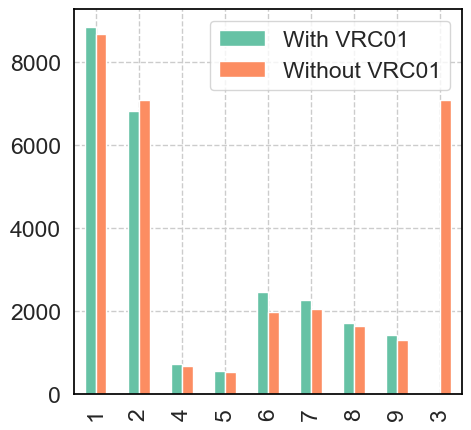

In [91]:
bic_df.plot.bar()

#### BS

In [19]:
# ## Bootstrapping 8365-2:
# def gen_bootstrap_params(raw_umis, intial_params, n_iter):
#     params = {}

#     for i in range(n_iter): 

#         # x_signal = x_signal[x_signal<2000]
#         results = custom_mle_mix(x_signal, w_guess = 0.05, initials = intial_params)

#         popt=results.x
#         params[i] = popt

#     return params

model_BICs = {}
sample_BICs = {}
sample_metrics = {}
sample=1
umi='SARS-2'

params={}

for i in range(10): 
    # Separating out VRC01 cells
    lseq_non_vrc01, vrc01_df = separate_vrc01(dfs[sample])
    # Removing cells with >1 heavy chains
    lseq_non_vrc01 = lseq_non_vrc01[lseq_non_vrc01['N'] == 1]
    # Remove VRC01 with >1 heavy chain
    vrc01_df = vrc01_df[vrc01_df['N'] == 1]

    # if sample == '8365-2':
    #     lseq_non_vrc01 = lseq_non_vrc01.sample(50)

    # Fitting VRC01 noise distribution
    x_noise = (vrc01_df[umi])

    x_noise = x_noise[x_noise < np.percentile(x_noise, 99)]

    X_noise = np.ones_like(x_noise)

    x_signal = lseq_non_vrc01[umi].copy()
    # x_signal = x_signal[x_signal < np.percentile(x_signal,99)]
    x_signal = np.random.choice(x_signal, len(x_signal), replace=True)

    print(np.mean(x_signal))


    # break
    # model_noise_nb = dm.NegativeBinomial(x_noise,X_noise).fit(start_params=[1,1])

    #np.exp(3)`
    initial_guess_params = initial_guess_mix(x_signal, 0.5)

    alpha2, b2 = initial_guess_params[2], initial_guess_params[3]

    alpha1, b1 = mle_iid_nbinom(x_noise)
    
    # nBinomial MLE
    # n_noise, p_noise = model_noise_nb.params[0], model_noise_nb.params[1]

    # mu_noise = np.exp(model_noise_nb.params[0])
    # n_noise = 1/model_noise_nb.params[1]
    # p_noise = n_noise/(n_noise + mu_noise)
    # noise_param2 = (1/p_noise)-1 
    
    nBinom_res = custom_mle_mix(x_signal, w_guess = 0.9, initials = (1, 1, alpha1, b1))
    sample_BICs['nBinom'] = nBinom_res.fun
    sample_metrics['nBinom'] = nBinom_res.x

    params[i] = nBinom_res.x
    model_BICs[i] = sample_BICs

3.235279625523528
3.156442473515644
3.2798718896279873
3.066026114806603
3.215570337521557
3.429169746242917
3.4791820645479183
3.5038186745503817
3.2916974624291697
3.438038925843804


In [12]:
paramdf = pd.DataFrame.from_dict(params, orient='index', columns = ['a1', 'b1', 'a2', 'b2', 'w'])

<Axes: xlabel='a2', ylabel='b2'>

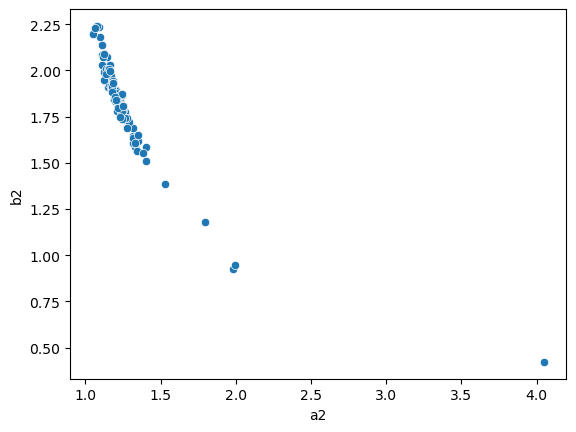

In [13]:
sns.scatterplot(x=paramdf['a2'], y=paramdf['b2'])

<Axes: xlabel='w', ylabel='Count'>

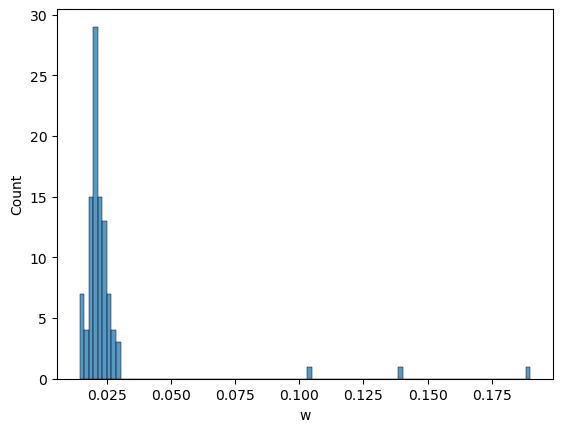

In [14]:
sns.histplot(paramdf['w'])

In [17]:
sample_BICs

{'nBinom': 8928.170904914976}

In [21]:
model_BIC_df = pd.DataFrame(model_BICs)
model_BIC_df

,0,1,2,3,4,5,6,7,8,9
nBinom,8864.872868,8864.872868,8864.872868,8864.872868,8864.872868,8864.872868,8864.872868,8864.872868,8864.872868,8864.872868


--------------------------------

### Plotting

In [13]:
def convert_params(popt):
    '''Convert mixed distribution parameters to be n and p for use with Scipy nbinom'''
    n_signal = popt[0]
    p_signal = 1/(1 + popt[1])
    n_noise = popt[2]
    p_noise= 1/(1 + popt[3])
    w = popt[4]

    return n_signal, p_signal, n_noise, p_noise, w

In [14]:
def calculate_component_probabilities(lseq_df, umi, popt):

    probdf = lseq_df.copy()
    n_signal, p_signal, n_noise, p_noise, weight = convert_params(popt)

    probdf['pmf'] = (st.nbinom.pmf(probdf[umi], n_signal, p_signal))
    probdf['pmf_noise'] = (st.nbinom.pmf(probdf[umi], n_noise, p_noise))

    probsA = pd.Series(len(probdf))
    probsB = pd.Series(len(probdf))

    for i in range(len(probdf['pmf'])):
        # Using Baye's theorem to get probabilities from pmf
        pxa = (weight)*(probdf['pmf'].iloc[i])
        pxb = (1-weight)*(probdf['pmf_noise'].iloc[i])
        Px = pxa + pxb
        Pa = pxa/Px
        Pb = pxb/Px
        probsA[i]  = Pa
        probsB[i]  = Pb

    probsB.index = probdf.index
    probsA.index = probdf.index
    probdf['probsB'] = probsB
    probdf['probsA'] = probsA
    if st.nbinom.median(n_signal, p_signal) < st.nbinom.median(n_noise, p_noise):
        probdf['probsB'] = probsA
        probdf['probsA'] = probsB
    return probdf

323.25298742220934
248.72751809275837
2348.7339239584244
74.3997447733541
45.89251492041525
44.926050765708155
97.89913801655021
126.8303538205893
95.2371313424736


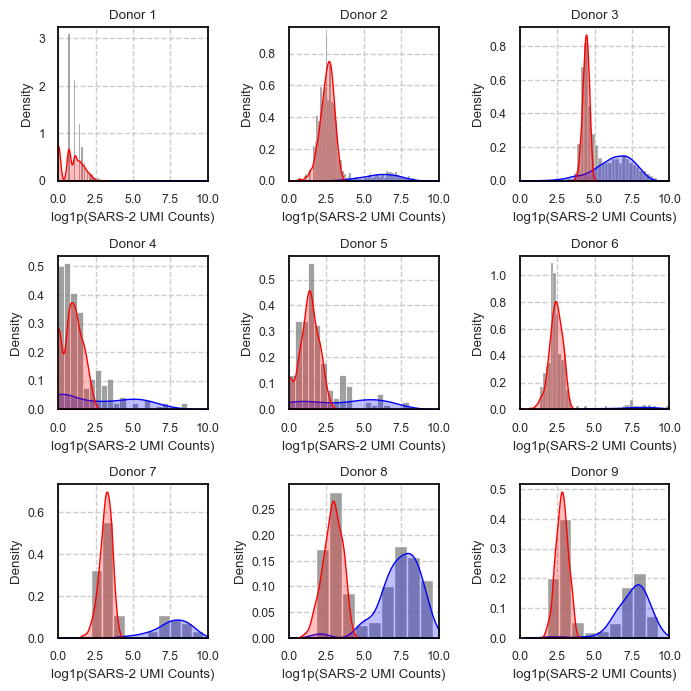

In [16]:
sns.set(rc = {'figure.figsize':(9,9)}, font_scale=0.8, palette='Set2')
sns.set_style("whitegrid", { "ytick.major.size": 0.1, "ytick.minor.size": 0.05, 'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True, 'axes.spines.top': True})

flipped_samples = []
all_probs = {}
samp_counts = {}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 7))
axes = axes.flatten()

count = 0
for sample in model_metrics:
# for sample in ['8365-1']:
    # plt.figure()

    n_noise, p_noise, n_signal, p_signal,w = convert_params(model_metrics[sample]['nBinom'])
    # n_noise, p_noise, n_signal, p_signal, w = convert_params(paramdf.median())

    lseq_non_vrc01, vrc01_df = separate_vrc01(dfs[sample])
    lseq_non_vrc01 = lseq_non_vrc01[lseq_non_vrc01['N'] ==1]
    probdf = lseq_non_vrc01.copy()

    vrc01_df = vrc01_df[vrc01_df['N'] == 1]


    if sample != '8365':
        counts = {}
        counts['Total'] = len(lseq_non_vrc01)
        counts['VRC01'] = len(vrc01_df)
        counts['BG505'] = len(lseq_non_vrc01[lseq_non_vrc01[umi] > np.mean(lseq_non_vrc01['BG505_sc'])])
        counts['10'] = len(lseq_non_vrc01[lseq_non_vrc01[umi] > 10])
        samp_counts[sample] = counts


    x_signal = lseq_non_vrc01[umi]

    # Randomly sampling from distribution for plotting KDE
    samples_noise = st.nbinom.rvs(n_noise, p_noise, size = int((w)*len(x_signal)))
    samples_signal = st.nbinom.rvs(n_signal, p_signal, size = int((1-w)*len(x_signal)))

    pdf = pd.DataFrame([samples_noise,samples_signal]).T
    if np.mean(samples_signal) < np.mean(samples_noise):
        pdf = pd.DataFrame([samples_signal, samples_noise]).T
        flipped_samples.append(sample)
    pdf.columns = ['Noise', 'Signal']
    
    pdf = np.log1p(pdf)
    # sns.histplot(np.log1p(x_signal), kde=False,stat="density", bins=2000, color='black')
    # sns.displot(np.log1p(x_signal),kind='hist', stat='density', color='black', alpha=0.5)
    # sns.histplot(np.log1p(x_signal), kde=False,stat="density", color='grey', bins=100, label='Real UMIs') #, label='Real UMIs') #,ax = axes[0])

    sns.histplot( np.log1p(x_signal), kde=False,stat="density", color='grey', label='Real UMIs', ax=axes[count], legend=False) #, label='Real UMIs') #,ax = axes[0])
    sns.kdeplot(data = pdf, fill=True, common_norm=True, palette=['red', 'blue'], ax=axes[count], legend=False)

    # plt.legend()
    # plt.legend(loc="right", bbox_to_anchor=(1,0.55), ncol= 1)
    axes[count].set(xlim = (0,10))
    axes[count].set(xlabel =('log1p(SARS-2 UMI Counts)'))
    axes[count].set(title = ('Donor ' + str(sample)))
    
    # print(sample + ' # of cells: ' + str(len(x_signal)))
    print(len(x_signal) * w)

    all_probs[sample] = calculate_component_probabilities(lseq_non_vrc01, 'SARS-2', model_metrics[sample]['nBinom'])
    # all_probs[sample] = calculate_component_probabilities(lseq_non_vrc01, 'SARS-2', paramdf.median())
    count +=1


plt.tight_layout()
# plt.savefig('mixed_dist_fit_' + 'panels' +'_manuscript_23-09-26.svg')
    # if sample == 2:
    #     break

In [41]:
def find_closest_values(s, x):
    idx = (np.abs(s - x)).argmin()
    return idx

In [44]:
# Get threshold
all_probs[1].iloc[find_closest_values(all_probs[1]['probsA'], 0.5)]['SARS-2']

7

C:\Users\perry\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='SARS-2.LSS', ylabel='probsA'>

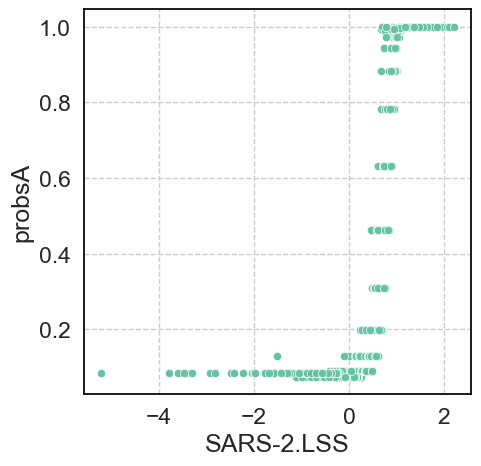

In [46]:
sns.scatterplot(y=all_probs[1]['probsA'], x=np.log1p(all_probs[1]['SARS-2.LSS']))

In [304]:
pd.DataFrame(samp_counts).T.to_clipboard()

In [305]:
# break

### bringing in ELISA

In [56]:
elisa_df = pd.read_csv('C:/Users/perry/Desktop/Atlas_analysis/ordering_abs/ELISA/elisa_df_tabular_23-07-31.csv', index_col=0)
# elisa_ab_names = pd.read_csv('C:/Users/perry/Desktop/Atlas_analysis/ordering_abs/ELISA/barcode_Ab_names_23-07-31.csv', index_col=0)
elisa_ab_names = pd.read_csv('C:/Users/perry/Desktop/Atlas_analysis/ordering_abs/ELISA/all_100_mAbs_names_lseqdata_23-07-31.csv', index_col=0)

elisa_ab_names.index = elisa_ab_names['BARCODE'] # Note: there are also intermediate TF tags, but I am not using these for now
elisa_barcodes = pd.read_csv('C:/Users/perry/Desktop/Atlas_analysis/ordering_abs/ELISA/sample_concat_barcodes_23-07-31.csv', index_col=0)

# mAbs 183 and 185 were identical, removed 185
elisa_ab_names = elisa_ab_names[elisa_ab_names['Name'] != '185']
elisa_df = elisa_df[elisa_df['Name'] != '185']

elisa_barcodes['Sample'] = elisa_barcodes.index
elisa_barcodes.index = elisa_barcodes.BARCODE
elisa_df['Sample_bc'] = elisa_barcodes['Sample']

elisa_df.index = elisa_df['Sample_bc']
elisa_df.index.name = 'Barcode'
elisa_df = elisa_df[['Name', 'SARS_2']]

elisa_df = elisa_df.loc[elisa_df.index.dropna()]

In [57]:
elisa_ML = pd.read_csv('./ordering_abs/ELISA/ML_val_abs_ELISA_23-09-04.csv', index_col=0)
elisa_ML['SARS_2'] = elisa_ML[['Repeat1', 'Repeat2']].mean(axis=1)
elisa_ML = elisa_ML[['Name', 'SARS_2']]
elisa_df = pd.concat([elisa_df, elisa_ML]).copy()

In [308]:
elisa_int_barcodes = [
    "CGACTTCGTCCTCTTG-8365-1",
    "GGCAATTGTTATCACG-8365-1",
    "GGGTCTGGTCAACTGT-8365-1",
    "GTCACAATCCTAAGTG-8365-1",
    "GTTTCTAAGACGCTTT-8365-1",
    "CATCAGACAAGACACG-8365-1",
    "TGCGTGGTCCGCAAGC-8365-1",
    "TACTTACAGCCAGGAT-8365-1",
    "ATAAGAGTCCTGCCAT-8365-1",
    "TGACAACCAGTCAGAG-8365-1",
    "AGAGCTTCAGCCAATT-8365-1",
    
    "CGGGTCACACCACGTG-8365-2",
    "ACGCCAGCAGGGAGAG-8365-2",
    "CGAGCACCAAGGTTTC-8365-2",
    "TCCACACGTTAAAGAC-8365-2",
    "TATCTCATCAAGGTAA-8365-2",
    "TAAACCGCACCGGAAA-8365-2",
    "GTGTTAGAGTCCAGGA-8365-2",
    "TCGAGGCCATCACAAC-8365-2",
    "ATTGGACTCTTACCGC-8365-2",
    "CTCGAAAGTGCAGACA-8365-2",
    
    "TGGTTAGCATTTGCCC-8365-3",
    "CGAGCACAGTGGTCCC-8365-3",
    "AGAATAGCAATGGACG-8365-3",
    "TTCGAAGAGATATGCA-8365-3",
    "TACTCGCTCAGTACGT-8365-3",
    "ACACCCTCAGACTCGC-8365-3",
    "ATGTGTGGTGGGTATG-8365-3",
    "CCACTACAGCTAAACA-8365-3",
    "TGTGTTTTCAGGCAAG-8365-3",
    "AGCGTCGGTCTTCGTC-8365-3"
]


In [58]:
sars2_elisa_df = elisa_df[~elisa_df['SARS_2'].isna()]
# sars2_elisa_df.index = sars2_elisa_df['Sample_bc']

prob_dfs = all_probs.copy()

# sars2_int_barcodes = np.intersect1d(elisa_int_barcodes, sars2_elisa_df.index)
# sars2_elisa_df = sars2_elisa_df.loc[sars2_int_barcodes]

sars2_values = {}
for i in prob_dfs:
    lseq_df = prob_dfs[i].copy()
    lseq_df.index = lseq_df.index + '-' +  '8365-' + str(i) 
    
    elisa_overlap = (sars2_elisa_df.loc[np.intersect1d(sars2_elisa_df.index, lseq_df.index)])

    sars2_lss = lseq_df.loc[elisa_overlap.index][umi + '.LSS']

    elisa_overlap['prob'] = round(lseq_df.loc[elisa_overlap.index]['probsA'],3)
    elisa_overlap['LSS'] = sars2_lss
    elisa_overlap['UMIs'] = lseq_df.loc[elisa_overlap.index][umi]
    num_cells = elisa_overlap.shape[0]
    if num_cells > 0:
        print(i)
        print(num_cells)

        sars2_values[i] = elisa_overlap[['Name', 'SARS_2', 'LSS', 'prob', 'UMIs']]

1
8
2
5
3
6
5
2
6
1


In [35]:
pd.concat(sars2_values).to_clipboard()

In [59]:
pd.concat(sars2_values)

Name  SARS_2        LSS   prob   UMIs
  Barcode                                                      
1 ATCCGAAGTTTCCACC-8365-1  135   0.091   0.045741  0.016      3
  CGACTTCGTCCTCTTG-8365-1  152   0.123   1.820374  0.490     14
  CTCAGAAGTCAGCTAT-8365-1  154   0.066   0.196396  0.016      3
  GGCAATTGTTATCACG-8365-1  151   0.072   1.881304  0.490     14
  GGGTCTGGTCAACTGT-8365-1  153   0.072   1.500813  0.378     13
  GTTTCTAAGACGCTTT-8365-1  140   3.245   0.157596  0.016      3
  TAGCCGGCAGCGTAAG-8365-1  136   0.064  -0.910449  0.019      1
  TCGCGAGGTCTTCTCG-8365-1  146   0.136   8.038097  1.000   4752
2 ACGCCAGCAGGGAGAG-8365-2  149   0.078   1.419758  1.000     87
  CGAGCACCAAGGTTTC-8365-2  141   0.089   1.143706  1.000     81
  CGGGTCACACCACGTG-8365-2  148   1.513   1.649414  1.000    101
  GCTTCCAAGTCCTCCT-8365-2  155   0.058  -0.662747  0.007      9
  GGCAATTTCCATGAGT-8365-2  145   0.149   4.580647  1.000    958
3 AGAATAGCAATGGACG-8365-3  116   3.036   0.541981  1.000    271
  AGCGTCGGTCTTCGTC-8365-3  139   3.268   0.856243  1.000    283
  CGAGCACAGTGGTCCC-8365-3  117   2.012   0.583968  1.000    311
  CGTCACTCACCGGAAA-8365-3  157   3.291   3.235351  1.000  14494
  CTACGTCTCTCCCTGA-8365-3  156   3.284   3.304751  1.000  11043
  GCTCTGTCATATGAGA-8365-3  158   0.101  -0.684420  0.050     84
5 TAGGCATAGATGTCGG-8365-5  133   0.099   0.160246  0.053      5
  TTTACTGGTCATCGGC-8365-5  134   0.112  -0.336600  0.048      3
6 CTAATGGGTGCCTTGG-8365-6  159   2.568  11.072320  1.000  25127

In [312]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
final_df = pd.concat(sars2_values)


### Figure S 2/3

In [26]:
lseq_non_vrc01['SARS-2']

Series([], Name: SARS-2, dtype: int64)

In [35]:
lseq_non_vrc01, vrc01_df  = separate_vrc01(dfs[i])

In [34]:
i

3

In [30]:
donor = lseq_non_vrc01['SARS-2']
donor

Series([], Name: SARS-2, dtype: int64)

In [70]:
donor_dfs = {}
vrc01_dfs = {}
for i in dfs:
    lseq_non_vrc01, vrc01_df = separate_vrc01(dfs[i])

    donor = lseq_non_vrc01['SARS-2']
    donor = donor[donor < np.percentile(donor, 99)]
    donor_dfs[i] = np.log1p(donor)

   
    vrc01 = vrc01_df['SARS-2']
    if i != 3:
        vrc01 = vrc01[vrc01 < np.percentile(vrc01, 99)]
    vrc01_dfs[i] = np.log1p(vrc01)


In [ ]:
vrc01_dfs[3] = 

In [88]:
def histplot_grid(dfs, ncols, width, output_name): # sample_col, x_col, y_col, 
    
    # Get unique samples
    unique_samples = dfs.keys()
    n = len(unique_samples)
    
    # Calculate number of rows required for the grid
    nrows = int(np.ceil(n / ncols))
    
    # Initialize the plot
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, nrows * 3))
    axes = axes.flatten()

    count = 0    
    for sample in dfs.keys():
        sample_df = dfs[sample]
        print(sample)
        sns.histplot(ax=axes[count], data = dfs[sample], stat='count', binwidth=0.15) #, color='grey'
    
            
        axes[count].set_title(f'Donor {sample}')
        axes[count].set_xlabel('log1p(SARS-2 UMI counts)')
        axes[count].set_ylabel('Count')
        axes[count].set_xlim(0,10)
        #     axes[i].set_ylabel(y_col)
        count  +=1
                
    # # Remove empty subplots
    # for i in range(n, nrows * ncols):
    #     fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig(output_name + '.svg')


1
2
3
4
5
6
7
8
9


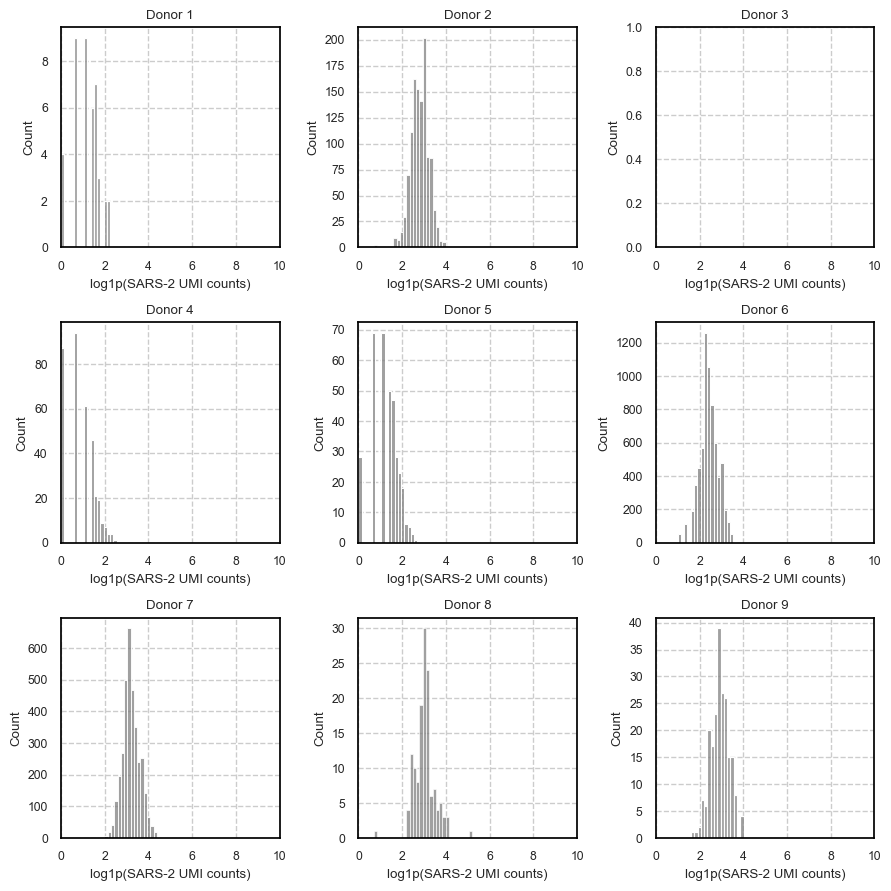

In [89]:
sns.set(rc = {'figure.figsize':(9,9)}, font_scale=0.8, palette='Set2')
sns.set_style("whitegrid", { "ytick.major.size": 0.1, "ytick.minor.size": 0.05, 'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True, 'axes.spines.top': True})

# histplot_grid(vrc01_dfs, 3, 9, 'vrc01_cell_distributions_S1_23-09-28.svg')
